# Inversion Play
This notebook is to simply to load and view inversions from real images to latent code. We can train an inversion here or we can load a pretrained inversion (recommended, since takes less time).

Remember, the point of GAN-Inversions is, given a real image I, find an latent code w such that G(w) = I, where G is our generator network.

We will approach this in 2 ways: 
1. Train an encoder E such that E(I) = w and G((E(I)) = G(w) = I (learning-based)
2. Optimize the latent code for a given instance through the generator network (optimization-based)

The first approach requires training, but then gives a latent vector directly. The second approach requires training for each instance. We decide to use a mix of the two approaches, that is: first train an encoder, and then use the output of the encoder as the initialization of 2. This will help avoid local minima.

It is important to note that once we load the checkpoint and load the w latent vector, we can use the notebook "StyleGAN Play" to edit the latent code (for example, style-mixing, interpolation), just like we did with our previous methods

## 0. Importing and Loading
We will need
* The StyleGAN generator (to visualize the projected latent code)
* The encoder E
* Viewing tools

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 


import pickle as pk
import sys
import os
import glob
sys.path.append('/home')

from asya_utils.latent_tools import get_projection_info
# from asya_utils.processing.network_postproc import normalize_tens
from asya_utils.model_tools.model_loaders import get_stylegan_models, get_encoder

In [2]:
device = 'cuda'
g_ema, disc, avg_w = get_stylegan_models(device=device)
g_ema.eval()

encoder = get_encoder('latent_image_pairs_500000_1024_1.pt', input_size=224, device=device)
encoder.eval()

avgw18 = avg_w.repeat(18).reshape([-1, 512])

input_size: 224


## 1. Training a projection
We will use the function in /home/Inversion/project
This notebook will go through a few ways to use the code.
This step is optional, normally all of the checkpoints are already saved and we can simply visualize them

First, let's give a real image that we want to use for our projection

In [3]:
# first, let's give
img = '/home/data/images/aligned_images/seb_01.png'

Here, we simply show different settings for optimization methods. We vary between:
1. My optimization method which initializes from a learned encoder E and regularizes the latent code accordingly. Optimize in W+ space.
2. My optimization method which initializes from an average vector w and regularizes the latent code accordingly. Optimize in W+ space. 
3. ImageToStyleGAN inversion method which first completely optimizes the latent code w and only then optimizes the noise vector. Optimize in W+ space.
4. StyleGAN inversion method with noise regularization. Optimize in W space.

In [4]:
# this is the default setting for "my" optimization
init_reg = 1e-7
!python /home/Inversion/project/train_latent.py --im_path $img --opt_w --opt_noise --init a --video --init_reg $init_reg --nb_it 700 --lr 0.0065


PERSON: seb_01
wandb dir: /home/datadrive/asya/checkpoints/stylegan2/w_projections/seb_01_18/opt_wn_init_a_run_2
optimizing w; initializing with average vector
 
 SHAPE OF LATENT INI :  torch.Size([1, 18, 512])

could not save program above cwd: /home/Inversion/project/train_latent.py
wandb: Currently logged in as: agrechka (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in /home/datadrive/asya/checkpoints/stylegan2/w_projections/seb_01_18/opt_wn_init_a_run_2/wandb/run-20201106_083353-1rxnxdh9
wandb: Syncing run opt_wn_init_a_run_2
wandb: ⭐️ View project at https://wandb.ai/agrechka/w_seb_01
wandb: 🚀 View run at https://wandb.ai/agrechka/w_seb_01/runs/1rxnxdh9
wandb: Run `wandb off` to turn off syncing.

save direcrtory for wandb /home/datadrive/asya/checkpoints/stylegan2/w_projections/seb_01_18/opt_wn_ini

In [5]:
# this is the default setting for "my" optimization with encoder
init_reg = 1e-7
!python /home/Inversion/project/train_latent.py --im_path $img --opt_w --opt_noise --init e --video --init_reg $init_reg --nb_it 1500 --lr 0.0065


PERSON: seb_01
wandb dir: /home/datadrive/asya/checkpoints/stylegan2/w_projections/seb_01_18/opt_wn_init_e_run_1
optimizing w; intializing with encoded image
input_size: 224
 
 SHAPE OF LATENT INI :  torch.Size([1, 18, 512])

could not save program above cwd: /home/Inversion/project/train_latent.py
wandb: Currently logged in as: agrechka (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in /home/datadrive/asya/checkpoints/stylegan2/w_projections/seb_01_18/opt_wn_init_e_run_1/wandb/run-20201106_080906-z9925f4y
wandb: Syncing run opt_wn_init_e_run_1
wandb: ⭐️ View project at https://wandb.ai/agrechka/w_seb_01
wandb: 🚀 View run at https://wandb.ai/agrechka/w_seb_01/runs/z9925f4y
wandb: Run `wandb off` to turn off syncing.

save direcrtory for wandb /home/datadrive/asya/checkpoints/stylegan2/w_projections/seb_01

In [ ]:
# stylegan2's method
noise_reg = 1e-4
!python /home/Inversion/project/train_latent.py --im_path $img --nlatent 1 --noise_reg $noise_reg --opt_w --opt_noise --init a --video --nb_it 1500 --lr 0.0065


In [13]:
# image2stylegan method
# first step: only train the latent without the noise
!python /home/Inversion/project/train_latent.py --im_path $img --nlatent 18 --opt_w --init a --video --nb_it 1500 --lr 0.0065

#finish image2stylegan method
# second step: only train the noise without the latent
# find the checkpoint from the latent and train in
bp = "/home/datadrive/asya/checkpoints/stylegan2/w_projections/{}_18/opt_w_init_a_run_".format(os.path.splitext(im)[0])
last = sorted(glob.glob(bp + '*'))[-1]
sub = last.split('/')[-1]
!python /home/Inversion/project/train_latent.py --im_path $img --nlatent 18 --opt_noise --opt_noise_from $sub --video --init a --lr 0.1


PERSON: asya_01
wandb dir: /home/datadrive/asya/checkpoints/stylegan2/w_projections/asya_01_18/opt_w_init_a_run_4
optimizing w; initializing with average vector
 
 SHAPE OF LATENT INI :  torch.Size([1, 18, 512])

could not save program above cwd: /home/Inversion/project/train_latent.py
wandb: Currently logged in as: agrechka (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in /home/datadrive/asya/checkpoints/stylegan2/w_projections/asya_01_18/opt_w_init_a_run_4/wandb/run-20201105_192452-1jeihpbp
wandb: Syncing run opt_w_init_a_run_4
wandb: ⭐️ View project at https://wandb.ai/agrechka/w_asya_01
wandb: 🚀 View run at https://wandb.ai/agrechka/w_asya_01/runs/1jeihpbp
wandb: Run `wandb off` to turn off syncing.

save direcrtory for wandb /home/datadrive/asya/checkpoints/stylegan2/w_projections/asya_01_18/opt_w_i

NameError: name 'os' is not defined

## 2. Visualizing the projection
Here, we will visualize the projections. We will load the save checkpoints. Here, the trained_inversions.pk contains a dictionary of keys of methods, and each one gives keys of people names. We can view them directly. 

In [3]:
with open('trained_inversions.pk', 'rb') as f:
    inversions = pk.load(f)
    
print(inversions.keys())
print(inversions['mypaths_e'].keys())

dict_keys(['mypaths_e', 'mypaths_a', 'st', 'im2st'])
dict_keys(['loicito', 'sarah', 'margo', 'mcord', 'rihanna', 'morgan', 'kobe', 'indman', 'indian', 'victor_02', 'victor', 'sonia', 'paul', 'paola', 'marguerite', 'hung', 'dmitry', 'asya_1024', 'alberto', 'ValentinBinjacar', 'Tof', 'cristian', 'jeff', 'juliette', 'gaetan', 'asya'])


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
/home/datadrive/asya/checkpoints/stylegan2/w_projections/asya_01_18/opt_wn_init_e_run_11/ckpt.pt
shape: torch.Size([1, 3, 1024, 1024])
		Original			Encoded			Optimized			No Noise


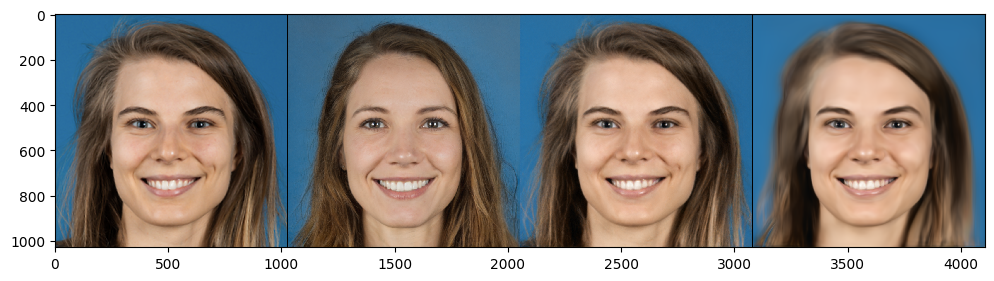

In [7]:
w_mine, noises_mine, scores = get_projection_info(inversions['mypaths_e']['asya'], encoder, g_ema)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
/home/datadrive/asya/checkpoints/stylegan2/w_projections/asya_01_18/opt_wn_init_a_run_5/ckpt.pt
shape: torch.Size([1, 3, 1024, 1024])
		Original			Encoded			Optimized			No Noise


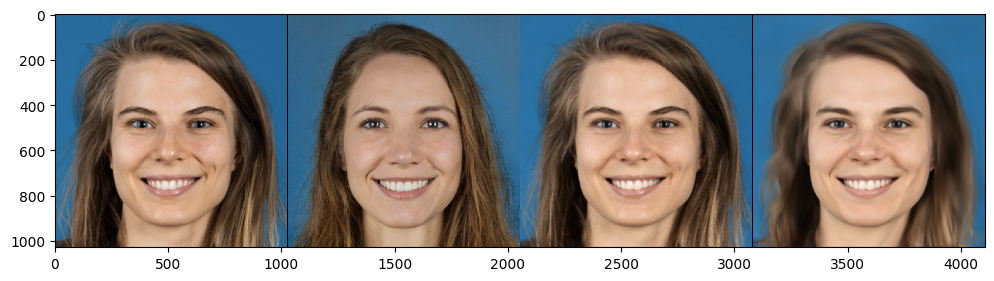

In [9]:
w_mine_a, noises_mine_a, scores_a = get_projection_info(inversions['mypaths_a']['asya'], encoder, g_ema)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
/home/datadrive/asya/checkpoints/stylegan2/w_projections/asya_01_18/opt_noise_opt_w_init_a_run_3_run_1/ckpt.pt
shape: torch.Size([1, 3, 1024, 1024])
		Original			Encoded			Optimized			No Noise


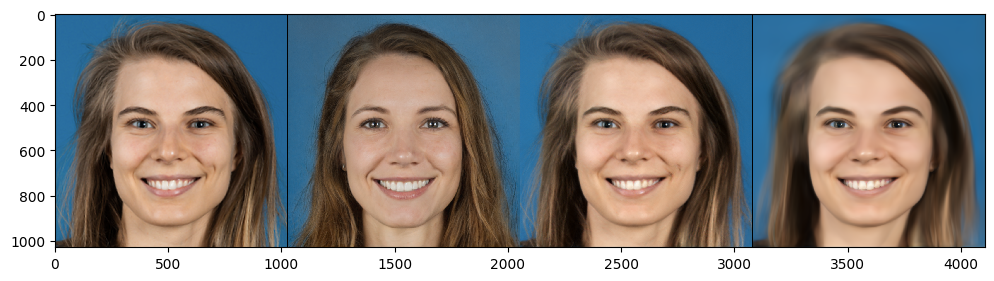

In [10]:
w_im2st, noises_im2st, scores_im2st = get_projection_info(inversions['im2st']['asya'], encoder, g_ema)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
/home/datadrive/asya/checkpoints/stylegan2/w_projections/asya_01_1/opt_wn_init_a_run_3/ckpt.pt
shape: torch.Size([1, 3, 1024, 1024])
		Original			Encoded			Optimized			No Noise


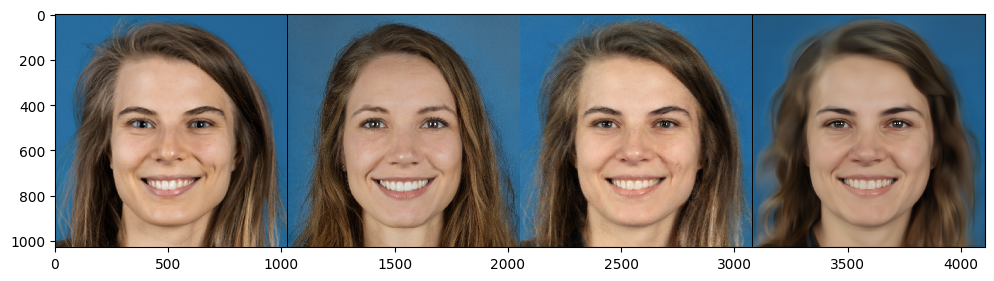

In [11]:
w_st, noises_st, scores_st = get_projection_info(inversions['st']['asya'], encoder, g_ema)

In [12]:
scores

{'lpips': 0.13913848996162415, 'mse_score': 0.0017548506148159504}

In [13]:
scores_a

{'lpips': 0.17031100392341614, 'mse_score': 0.0021483725868165493}

In [14]:
scores_im2st

{'lpips': 0.12312762439250946, 'mse_score': 0.0016369596123695374}

In [15]:
scores_st

{'lpips': 0.25572502613067627, 'mse_score': 0.004580650944262743}